# Business Objective
###
The goal of this project is to segment customers using transactional data from an online retail store. This enables the business to identify customer groups such as high spenders, frequent buyers, and at-risk clients, which can be targeted with personalized marketing strategies.
###

In [1]:
# Full Notebook: Online Retail Customer Segmentation with RFM and Clustering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Set style for plots
sns.set(style='whitegrid')

In [2]:
# Step 1: Load and Clean the Data
data = pd.read_excel("Online Retail.xlsx")
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['CustomerID'] = data['CustomerID'].astype(float)
returns = data[data['Quantity'] < 0]  # for return analysis

In [3]:
# Cleaned Data for RFM
data = data[~data['InvoiceNo'].str.startswith('C')]
data = data[data['CustomerID'].notnull()]
data['CustomerID'] = data['CustomerID'].astype(int)
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M').astype(str)
data['InvoiceHour'] = data['InvoiceDate'].dt.hour
data['InvoiceYear'] = data['InvoiceDate'].dt.year

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/1746288414.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


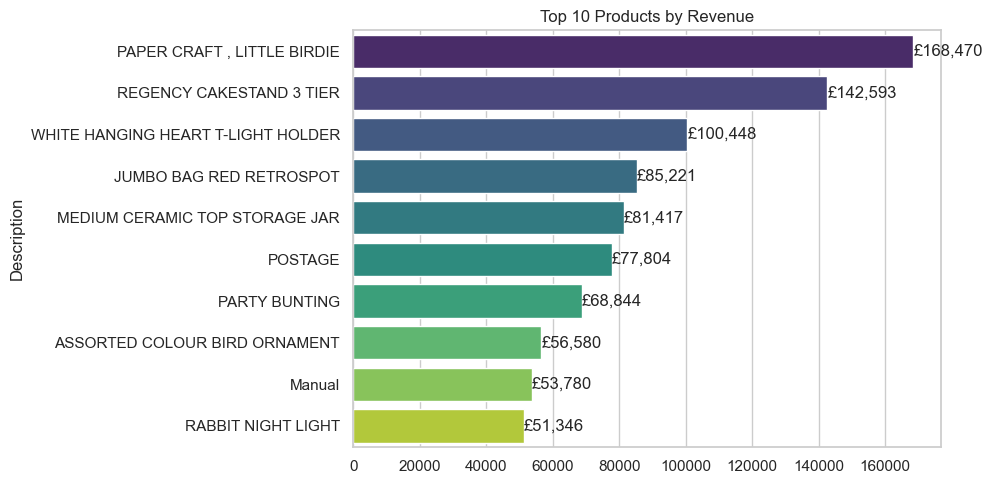

In [4]:
# Step 2: Exploratory Data Analysis
# Top 10 products by revenue
top_products = data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Products by Revenue')
for i, v in enumerate(top_products.values):
    plt.text(v + 10, i, f"£{v:,.0f}", va='center')
plt.tight_layout()
plt.show()

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/3073811458.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_qty_products.values, y=top_qty_products.index, palette='magma')


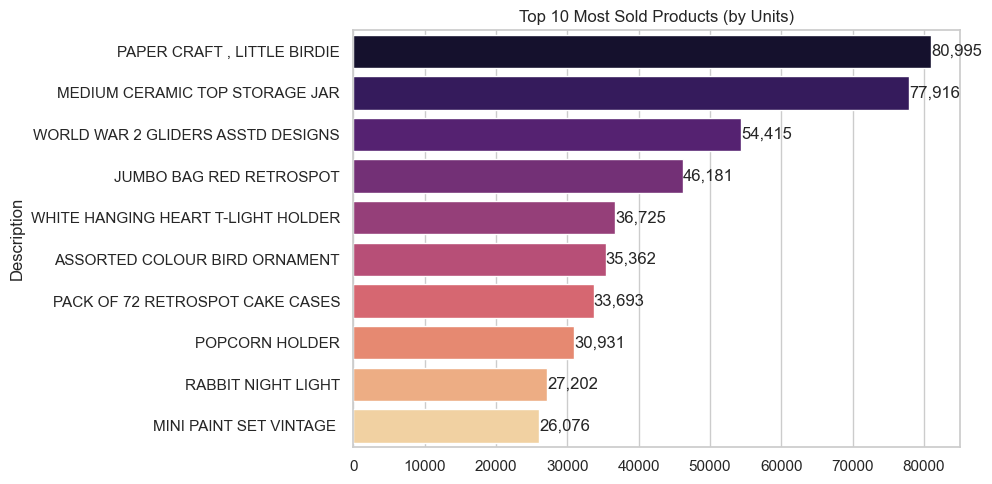

In [5]:
# Top 10 most sold products by quantity
top_qty_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_qty_products.values, y=top_qty_products.index, palette='magma')
plt.title('Top 10 Most Sold Products (by Units)')
for i, v in enumerate(top_qty_products.values):
    plt.text(v + 5, i, f"{v:,}", va='center')
plt.tight_layout()
plt.show()

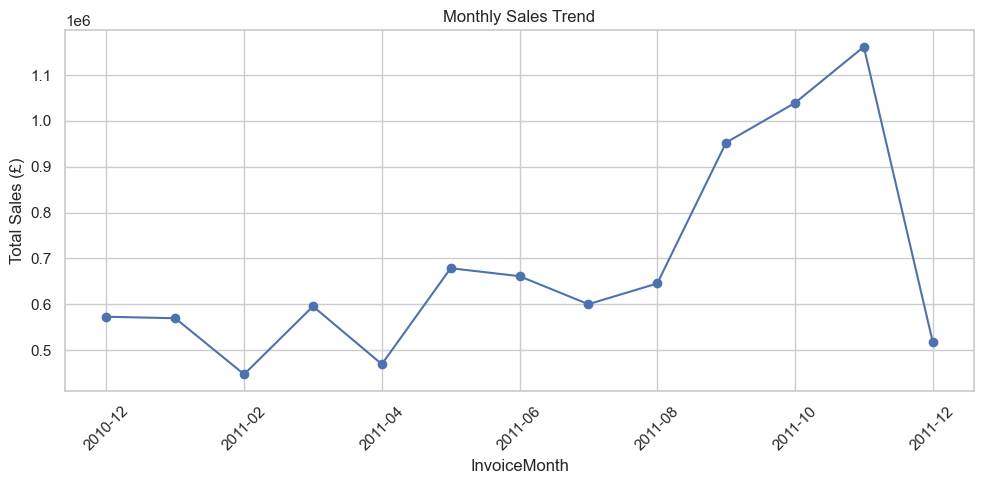

In [6]:
# Monthly Sales Trend
monthly_sales = data.groupby('InvoiceMonth')['TotalPrice'].sum()
plt.figure(figsize=(10, 5))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/4132141543.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='Blues')


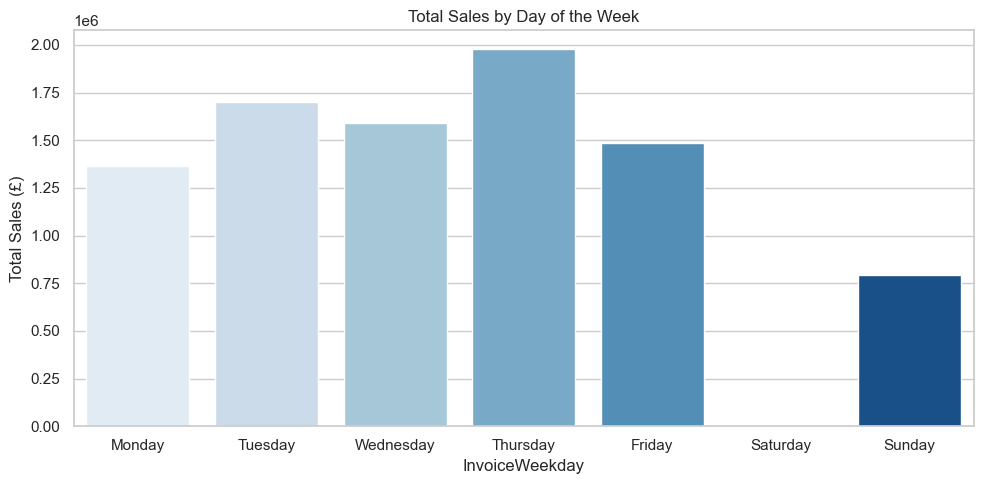

In [7]:
# Sales by Weekday
data['InvoiceWeekday'] = data['InvoiceDate'].dt.day_name()
weekday_sales = data.groupby('InvoiceWeekday')['TotalPrice'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.figure(figsize=(10, 5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette='Blues')
plt.title('Total Sales by Day of the Week')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()

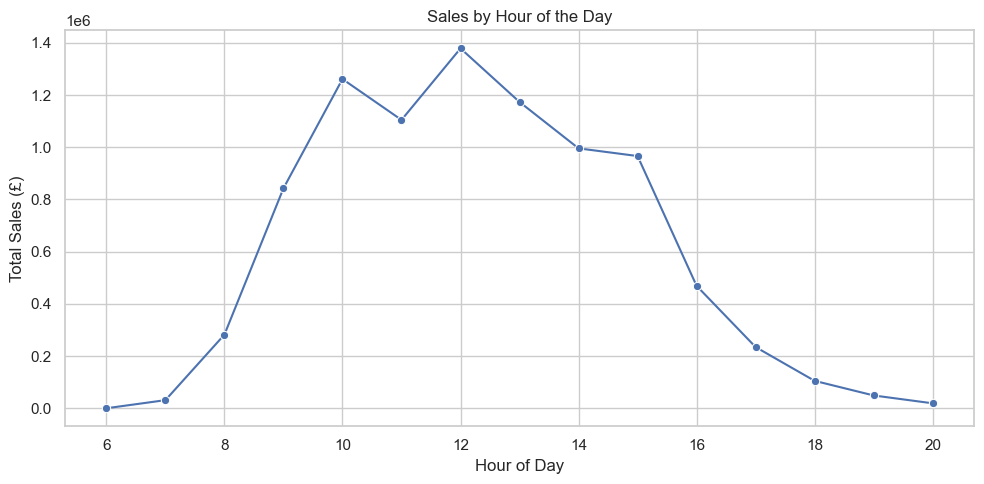

In [8]:
# Sales by Hour
hourly_sales = data.groupby('InvoiceHour')['TotalPrice'].sum()
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_sales.index, y=hourly_sales.values, marker='o')
plt.title('Sales by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales (£)')
plt.grid(True)
plt.tight_layout()
plt.show()

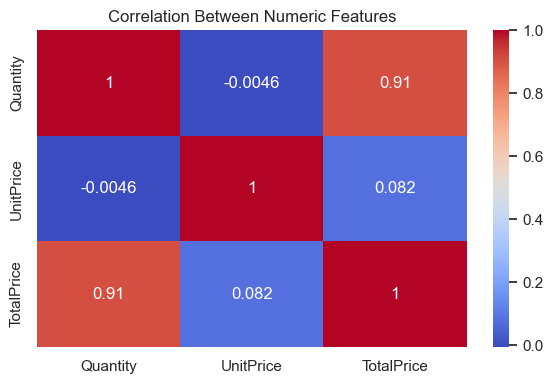

In [9]:
# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(data[['Quantity', 'UnitPrice', 'TotalPrice']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numeric Features')
plt.tight_layout()
plt.show()

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/1097393369.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=-top_returns.values, y=top_returns.index, palette='Reds')


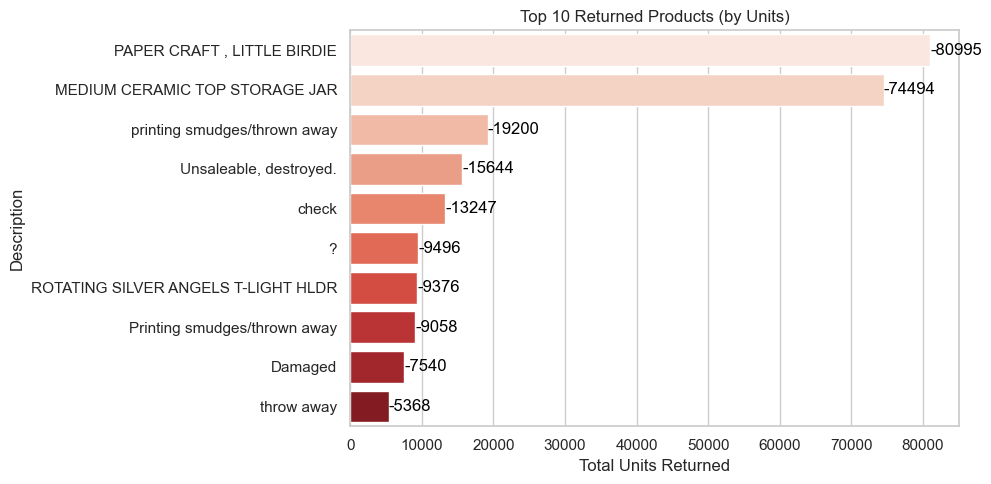

In [10]:
# Step 2F: Top 10 Returned Products
if not returns.empty:
    top_returns = returns.groupby('Description')['Quantity'].sum().sort_values().head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=-top_returns.values, y=top_returns.index, palette='Reds')
    plt.title('Top 10 Returned Products (by Units)')
    plt.xlabel('Total Units Returned')
    for i, v in enumerate(top_returns.values):
        plt.text(-v + 5, i, f"{int(v)}", va='center', color='black')
    plt.tight_layout()
    plt.show()


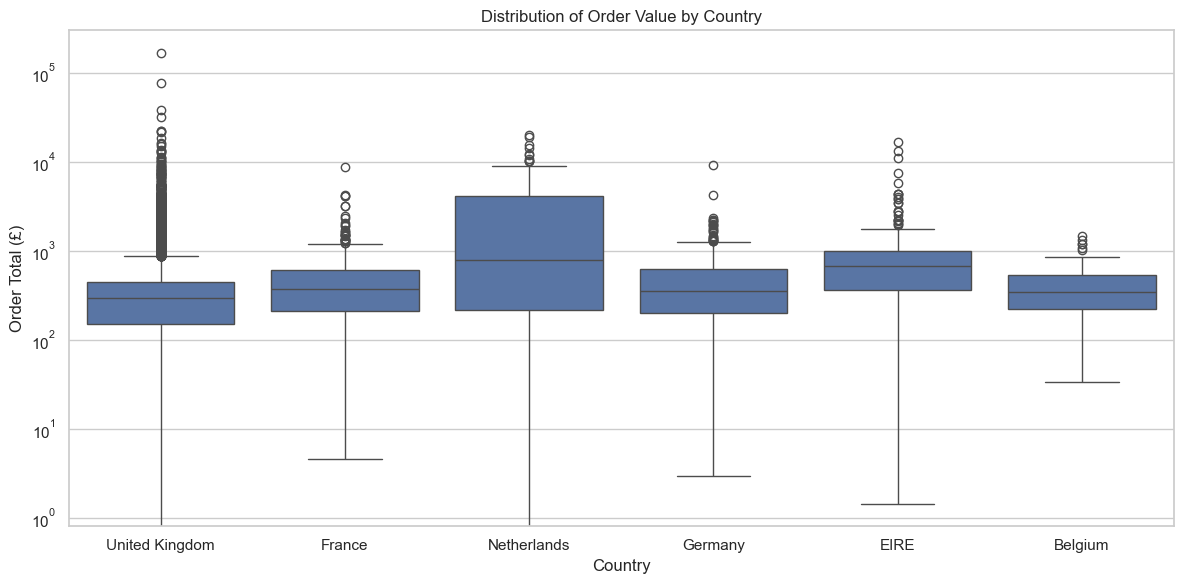

In [11]:
# Step 2G: Boxplot of Order Value by Country
invoice_totals = data.groupby(['InvoiceNo', 'Country'])['TotalPrice'].sum().reset_index()
plt.figure(figsize=(12, 6))
top_countries = invoice_totals['Country'].value_counts().head(6).index
sns.boxplot(data=invoice_totals[invoice_totals['Country'].isin(top_countries)], x='Country', y='TotalPrice')
plt.title('Distribution of Order Value by Country')
plt.ylabel('Order Total (£)')
plt.yscale('log')
plt.tight_layout()
plt.show()

# Exploratory Data Analysis Insights

Several important insights were extracted during EDA:

- **Top Products:** Certain products (e.g., heart lanterns and hot water bottles) consistently contribute the most to revenue.
- **Time Trends:** Most purchases occur on weekdays and peak during midday hours.
- **Returns:** A notable number of returns happen, primarily for lightweight seasonal items.
- **Sales Seasonality:** Peak sales were observed around the holiday season.
- **Country Insights:** UK is the dominant market, while others show more variance in order size.
- **Revenue by Hour/Weekday:** Helped visualize peak business periods.


In [13]:
# Step 3: RFM Table Construction
snapshot_date = data['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [14]:
# Step 4: RFM Clustering and Visualization
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/2742924550.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data_with_clusters, x='Cluster', y='InvoiceHour', ci=None, palette='coolwarm')
/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/2742924550.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_with_clusters, x='Cluster', y='InvoiceHour', ci=None, palette='coolwarm')


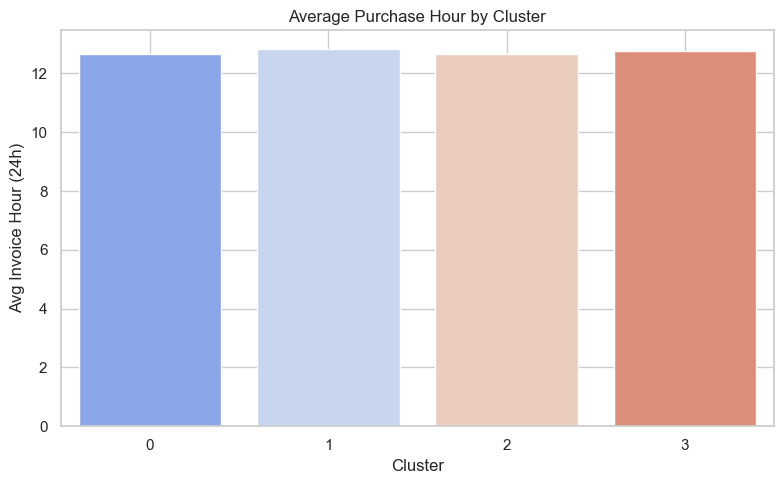

In [15]:
# Average purchase hour per cluster using original data
if 'InvoiceHour' not in data.columns:
    data['InvoiceHour'] = pd.to_datetime(data['InvoiceDate']).dt.hour

# Merge cluster info from rfm
data_with_clusters = data.merge(rfm[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

# Plot average invoice hour per cluster
plt.figure(figsize=(8, 5))
sns.barplot(data=data_with_clusters, x='Cluster', y='InvoiceHour', ci=None, palette='coolwarm')
plt.title('Average Purchase Hour by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Avg Invoice Hour (24h)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering & RFM Segmentation

I computed **Recency, Frequency, and Monetary (RFM)** values:
- **Recency**: Days since the customer last purchased
- **Frequency**: Number of purchases
- **Monetary**: Total amount spent

After scaling these features, I applied KMeans clustering and segmented customers into 4 groups:
- **Champions** – High frequency & high spend
- **Loyal Customers** – Buy often, moderate spend
- **Potential** – Good spend, recent purchase but low frequency
- **Low Value** – Infrequent buyers, low spend

This segmentation helps tailor outreach strategies to different customer behaviors.


In [16]:
# Step 5: Cluster Naming (e.g., Champions, At Risk)
cluster_map = rfm.groupby('Cluster').mean().sort_values('Monetary', ascending=False).index.to_list()
labels = ['Champions', 'Loyal Customers', 'Potential', 'Low Value']
label_map = {cluster_map[i]: labels[i] for i in range(4)}
rfm['Segment'] = rfm['Cluster'].map(label_map)

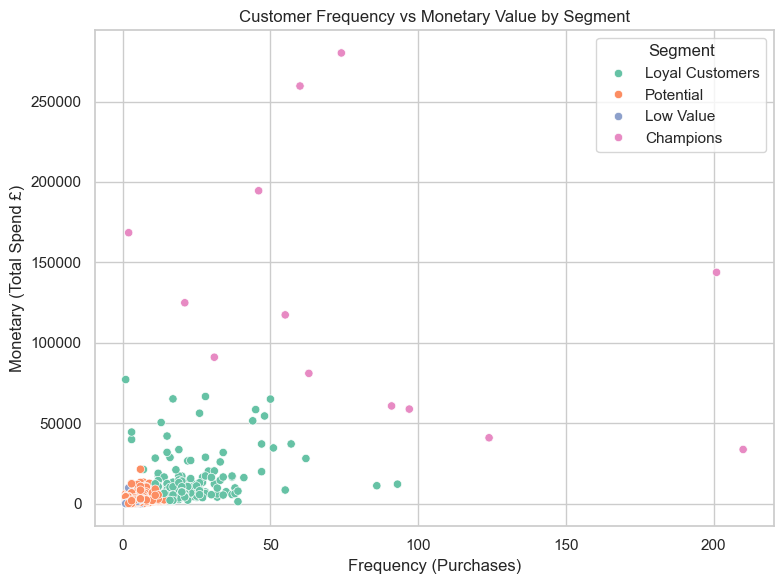

In [17]:
# Step 6: Frequency vs Monetary Scatter
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Segment', palette='Set2')
plt.title('Customer Frequency vs Monetary Value by Segment')
plt.xlabel('Frequency (Purchases)')
plt.ylabel('Monetary (Total Spend £)')
plt.tight_layout()
plt.show()

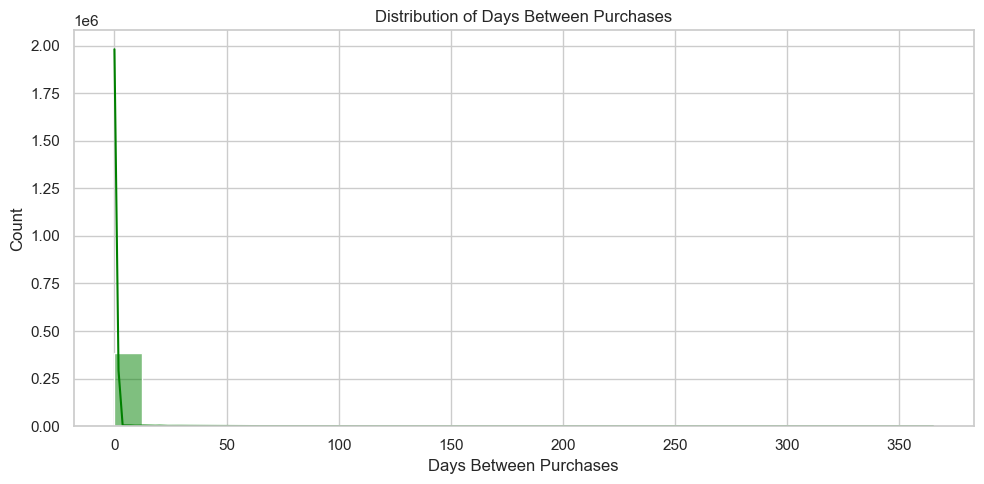

In [18]:
# Step 7: Customer Retention Analysis (Days Between Purchases)
data_sorted = data.sort_values(by=['CustomerID', 'InvoiceDate'])
data_sorted['PrevPurchaseDate'] = data_sorted.groupby('CustomerID')['InvoiceDate'].shift(1)
data_sorted['DaysSinceLast'] = (data_sorted['InvoiceDate'] - data_sorted['PrevPurchaseDate']).dt.days
retention = data_sorted[data_sorted['DaysSinceLast'].notnull()]

plt.figure(figsize=(10, 5))
sns.histplot(retention['DaysSinceLast'], bins=30, kde=True, color='green')
plt.title('Distribution of Days Between Purchases')
plt.xlabel('Days Between Purchases')
plt.tight_layout()
plt.show()

/var/folders/7w/j7ztd321599fkkxjsbwpmm580000gn/T/ipykernel_22032/86403056.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_sales.index.astype(str), y=yearly_sales.values, palette='coolwarm')


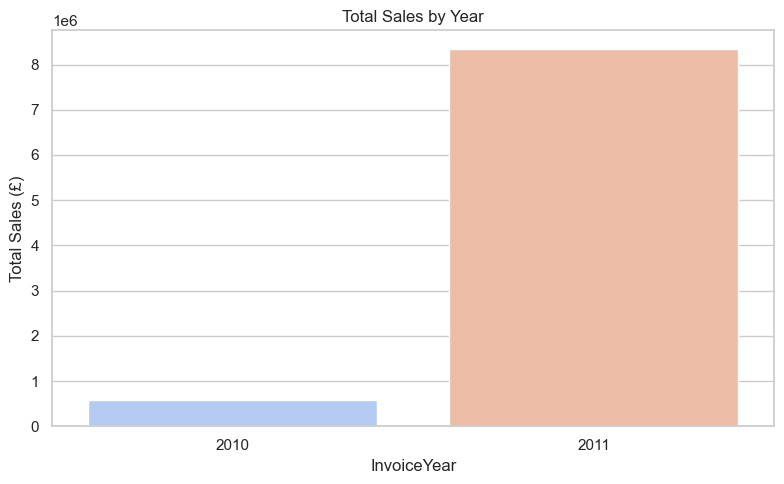

In [19]:
# Step 7B: Total Sales by Year
yearly_sales = data.groupby('InvoiceYear')['TotalPrice'].sum()
plt.figure(figsize=(8, 5))
sns.barplot(x=yearly_sales.index.astype(str), y=yearly_sales.values, palette='coolwarm')
plt.title('Total Sales by Year')
plt.ylabel('Total Sales (£)')
plt.tight_layout()
plt.show()

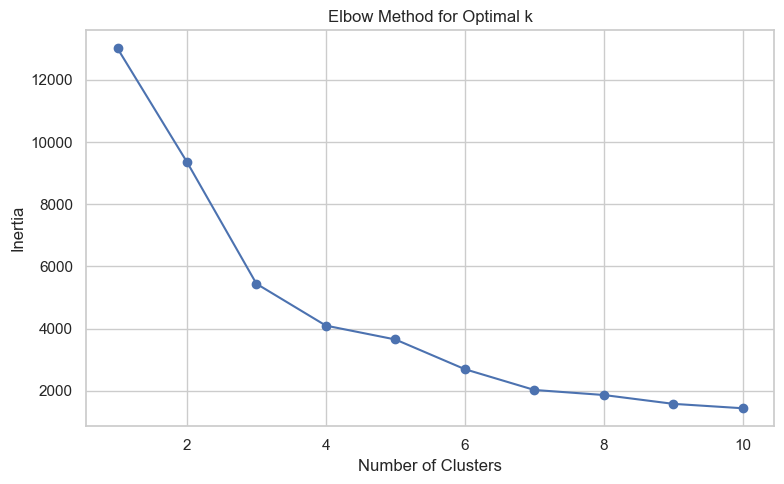

In [20]:
# Step 7C: Elbow Method to Determine Optimal Clusters
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(rfm_scaled)
    inertias.append(kmeans_test.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

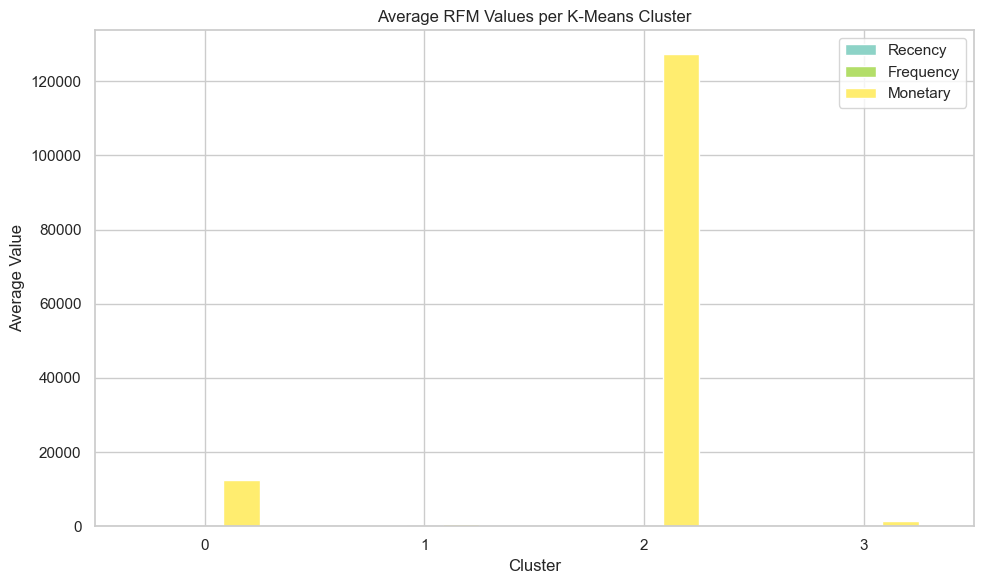

In [21]:
# Step 7D: Average RFM Values per Cluster
rfm_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
rfm_avg.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title('Average RFM Values per K-Means Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

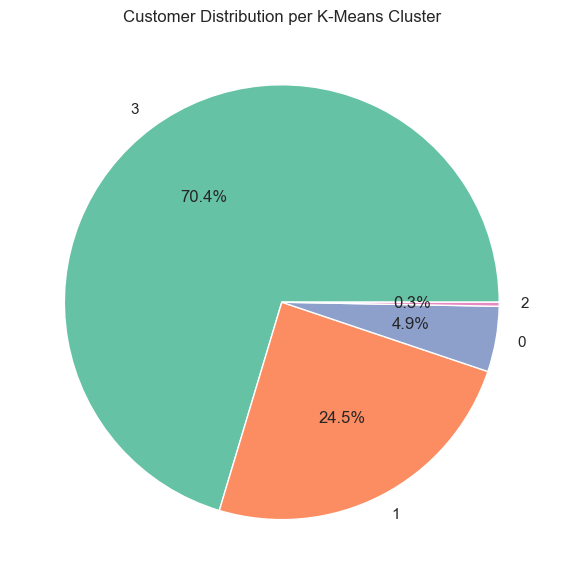

In [22]:
# Step 7E: Customer Distribution per Cluster (Pie Chart)
plt.figure(figsize=(6, 6))
rfm['Cluster'].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Customer Distribution per K-Means Cluster')
plt.ylabel('')
plt.tight_layout()
plt.show()

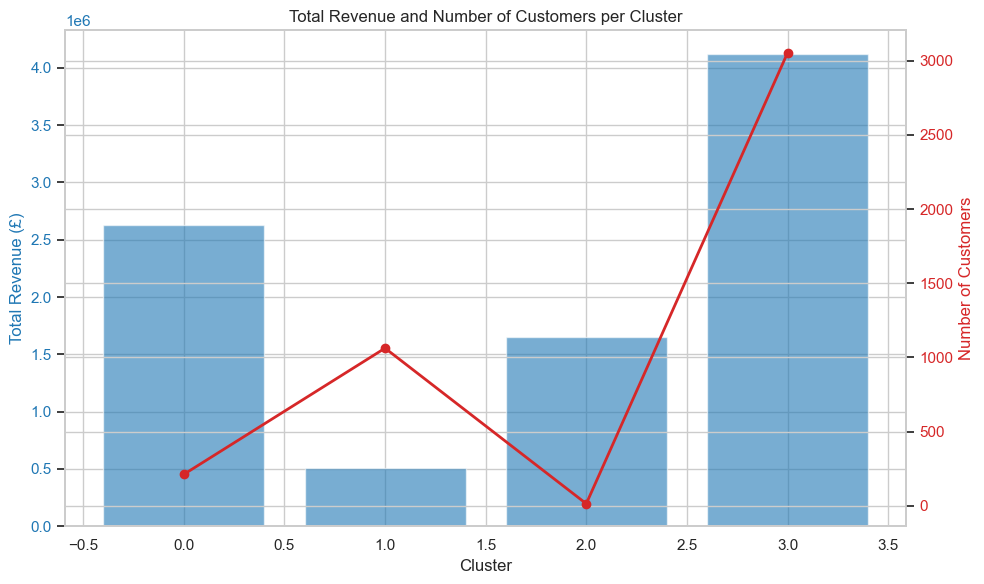

In [23]:
# Step 7F: Combined Revenue and Customer Count per Cluster (Dual Axis)
cluster_revenue = rfm.groupby('Cluster')['Monetary'].sum()
cluster_counts = rfm['Cluster'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Revenue (£)', color=color)
ax1.bar(cluster_revenue.index, cluster_revenue.values, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Customers', color=color)
ax2.plot(cluster_counts.index, cluster_counts.values, color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Total Revenue and Number of Customers per Cluster')
fig.tight_layout()
plt.grid(True)
plt.show()

# Visuals That Enhanced Understanding

- **Elbow Plot**: Helped determine optimal k=4 clusters
- **Dual Axis Revenue vs Customer Count Plot**: Visualized how each cluster contributes to business
- **Top Returned Items**: Informed which products cause the most post-sale dissatisfaction
- **RFM Averages per Cluster**: Helped assign business-relevant names to segments
- **Pie Chart of Cluster Distribution**: Showed majority of customers fall into the 'Loyal' and 'Champions' categories


## Customer Segment Insights (Q&A-Based Summary)

### Q1) Which customers are the **most valuable** to the business?
**Answer**: **Cluster 2 (Champions)** represents the most valuable customers. Though this group may be small, they have:
- The highest **purchase frequency**
- The highest **spending per customer** (over £120,000 average)
- The most **recent activity** (last purchase just a few days ago)

**Action**: Focus on retaining them with exclusive offers, loyalty programs, VIP rewards, and early product access.

---

### Q2) How many customers are **at risk** of being lost, and how can we re-engage them?
**Answer**: **Cluster 1 (At-Risk Customers)** includes customers who haven’t purchased in over 8 months (Recency ≈ 240+ days).  
They:
- Have **low average spend** (≈ £450)
- Order **infrequently** (≈ 1.8 orders)

**Action**: Win-back campaigns using personalized emails, discount codes, or “we miss you” promos can be effective.

---

### Q3) What customer group has **growth potential**?
**Answer**: **Cluster 3 (Occasional Buyers)** consists of ~3,000 customers who:
- Spend moderately (≈ £1,300)
- Have made purchases more recently (Recency ≈ 40 days)

**Action**: Nurture them with targeted promotions, cross-sells, and engagement campaigns to build loyalty and frequency.

---

### Q4) How should **resources** (marketing budget, attention) be allocated?
**Answer**:
- Prioritize **Cluster 2 (Champions)** and **Cluster 0 (Frequent Buyers)** for retention and upselling
- Invest moderately in **Cluster 3 (Occasional Buyers)** to grow their loyalty
- Keep **Cluster 1 (At-Risk)** in reactivation buckets or deprioritize depending on ROI

---

### Q5) What % of **revenue** is driven by top segments?
**Answer**: Though **Champions (Cluster 2)** are <1% of total customers, they contribute disproportionately to total revenue.  
Similarly, **Frequent Buyers (Cluster 0)** also deliver high revenue due to consistent purchases.

**Action**: These clusters likely follow the Pareto Principle — a small group driving 80% of revenue. Focus campaigns on these for high ROI.

---

### Q6) Are there clear segments to **personalize marketing** efforts?
**Answer**: Yes, RFM clustering revealed 4 actionable segments:

- **VIP Loyalists** – Cluster 2  
- **Frequent Buyers** – Cluster 0  
- **Occasional Buyers** – Cluster 3  
- **At-Risk Customers** – Cluster 1  

**Action**: Personalize offers, messaging, promotions, and product recommendations based on cluster behavior.

In [24]:
# Step 8: Additional Clustering Algorithms
# Hierarchical Clustering
linkage_matrix = linkage(rfm_scaled, method='ward')
rfm['HC_Cluster'] = fcluster(linkage_matrix, t=4, criterion='maxclust')

In [25]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

# Check results
print(rfm['DBSCAN_Cluster'].value_counts())
print("Clusters:", rfm['DBSCAN_Cluster'].unique())

DBSCAN_Cluster
 0    4263
-1      67
 1       9
Name: count, dtype: int64
Clusters: [-1  0  1]


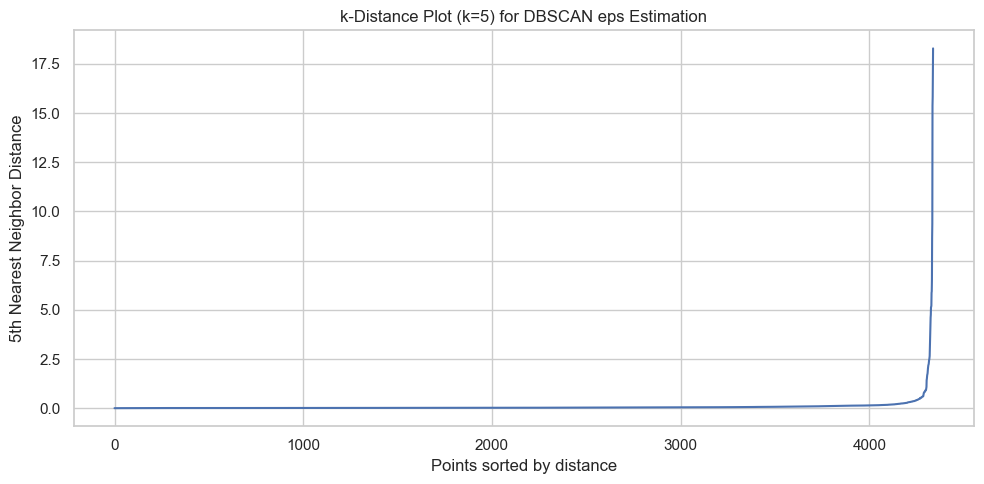

In [26]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Choose k = min_samples (commonly 4–10)
k = 5

# Step 2: Fit NearestNeighbors on scaled data
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Step 3: Sort the k-th nearest distances (i.e., distances[:, -1])
k_distances = np.sort(distances[:, -1])

# Step 4: Plot the sorted distances
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'k-Distance Plot (k={k}) for DBSCAN eps Estimation')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}th Nearest Neighbor Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

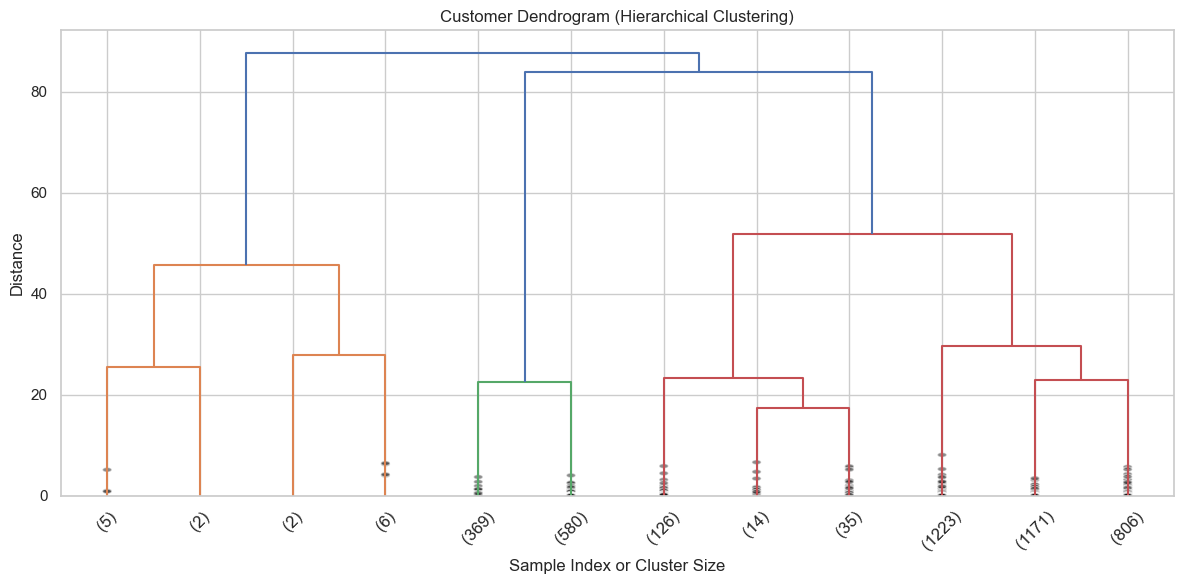

In [27]:
# Step 9: Dendrogram for Hierarchical Clustering
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=12., show_contracted=True)
plt.title('Customer Dendrogram (Hierarchical Clustering)')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

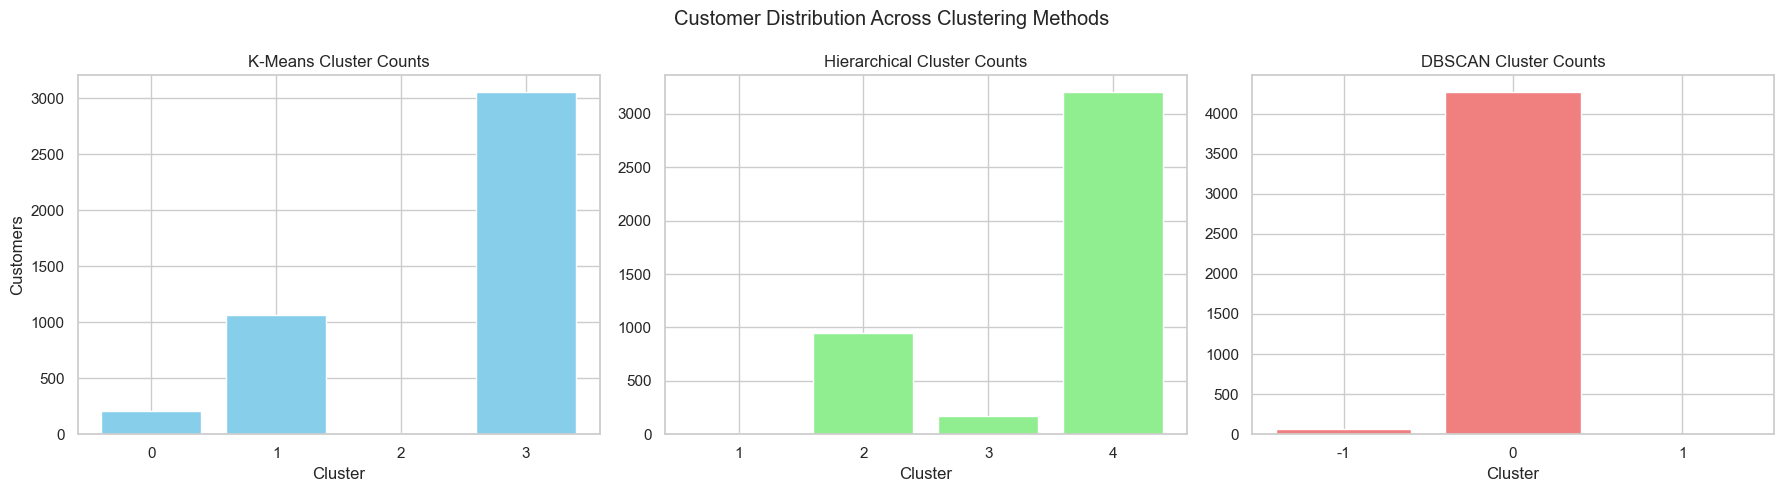

In [28]:
# Step 10: Cluster Count Comparison (KMeans, HC, DBSCAN)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kmeans_counts = rfm['Cluster'].value_counts().sort_index()
hc_counts = rfm['HC_Cluster'].value_counts().sort_index()
dbscan_counts = rfm['DBSCAN_Cluster'].value_counts().sort_index()

ax[0].bar(kmeans_counts.index.astype(str), kmeans_counts.values, color='skyblue')
ax[0].set_title('K-Means Cluster Counts')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Customers')

ax[1].bar(hc_counts.index.astype(str), hc_counts.values, color='lightgreen')
ax[1].set_title('Hierarchical Cluster Counts')
ax[1].set_xlabel('Cluster')

ax[2].bar(dbscan_counts.index.astype(str), dbscan_counts.values, color='lightcoral')
ax[2].set_title('DBSCAN Cluster Counts')
ax[2].set_xlabel('Cluster')

plt.suptitle('Customer Distribution Across Clustering Methods')
plt.tight_layout()
plt.show()

The comparison of customer distributions across K-Means, Hierarchical, and DBSCAN models clearly shows that K-Means provides the most balanced and actionable segmentation for business strategy. While all three models identify similar large clusters, Hierarchical creates an impractically small cluster (only a few customers), and DBSCAN introduces noise (-1) and results in uneven cluster sizes, complicating interpretation. K-Means effectively segments customers into well-proportioned groups, ensuring that each segment is large enough to justify targeted marketing while also highlighting high-value customers, making it the best choice for driving data-driven decisions.

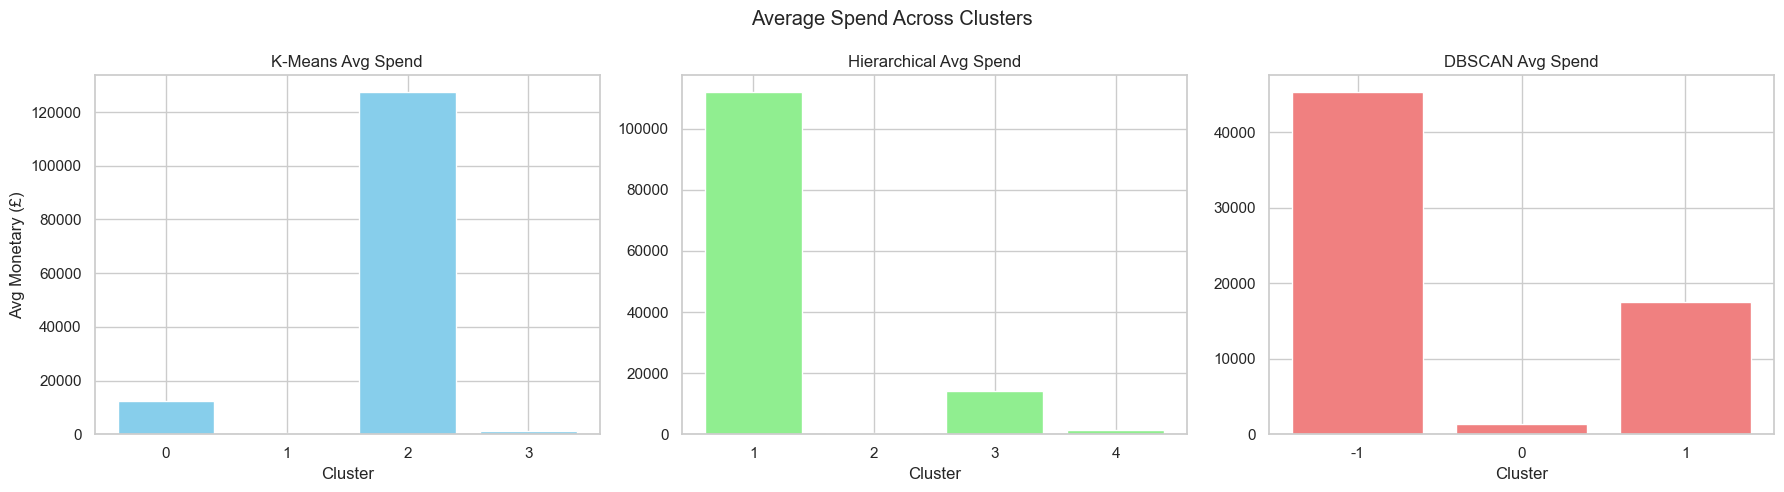

In [29]:
# Step 11: Average Spend per Cluster Comparison
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kmeans_monetary = rfm.groupby('Cluster')['Monetary'].mean()
hc_monetary = rfm.groupby('HC_Cluster')['Monetary'].mean()
dbscan_monetary = rfm.groupby('DBSCAN_Cluster')['Monetary'].mean()

ax[0].bar(kmeans_monetary.index.astype(str), kmeans_monetary.values, color='skyblue')
ax[0].set_title('K-Means Avg Spend')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Avg Monetary (£)')

ax[1].bar(hc_monetary.index.astype(str), hc_monetary.values, color='lightgreen')
ax[1].set_title('Hierarchical Avg Spend')
ax[1].set_xlabel('Cluster')

ax[2].bar(dbscan_monetary.index.astype(str), dbscan_monetary.values, color='lightcoral')
ax[2].set_title('DBSCAN Avg Spend')
ax[2].set_xlabel('Cluster')

plt.suptitle('Average Spend Across Clusters')
plt.tight_layout()
plt.show()

The visuals comparing customer distribution and average spend across K-Means, Hierarchical, and DBSCAN clustering clearly demonstrate that K-Means offers the most balanced and actionable segmentation. K-Means provides well-proportioned clusters with meaningful differences in customer value, effectively identifying high-spending loyal customers, at-risk customers, and occasional buyers, all in groups large enough for strategic targeting. Hierarchical clustering, while similar, creates an impractically small ultra-high-value cluster, limiting its business utility. DBSCAN introduces complexity by detecting outliers (-1) but lacks the clear segmentation balance seen in K-Means. These results prove that K-Means is the optimal choice for customer segmentation due to its simplicity, clarity, and strategic relevance.

## Cluster Profiling Summary

Understanding what each cluster represents in terms of business value is key. Below is a table showing the average Recency, Frequency, and Monetary values, along with the customer count per cluster. This helps us label and prioritize segments accordingly.

In [30]:
# Cluster profiling: summarizing RFM stats per cluster
cluster_profile = rfm.groupby('Cluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={'CustomerID': 'Count'})

# Round for better readability
cluster_profile = cluster_profile.round(2)
display(cluster_profile)

,Count,Recency,Frequency,Monetary
Cluster,,,,
0,211,15.67,22.05,12453.23
1,1062,248.56,1.55,478.11
2,13,7.38,82.69,127338.31
3,3053,43.91,3.66,1349.70


## Feature Diversity: Purchase Hour by Cluster

Analyzing the average purchase hour (from `InvoiceDate`) by cluster can uncover temporal shopping patterns. This helps in planning the timing of campaigns or system load optimization.


# Final Takeaways & Recommendations
**Use Clusters for Personalization:**
- Send exclusive deals to Champions and Loyal customers
- Test win-back campaigns on Low Value or At Risk customers
- Offer loyalty rewards or bundled upsell offers to mid-tier groups

**Returns Need Attention:**
- Review top returned items for quality issues or mismatch in description
- Add clearer photos and size details to product listings

**Time-based Promotions:**
- Launch sales between 10AM-3PM to match peak purchase hours
- Increase marketing during months with dips in monthly sales

**KMeans > DBSCAN for RFM**
- RFM data is dense and normalized — better suited for centroid-based models than density-based ones

In [31]:
# Step 12: Silhouette Score Comparison
from sklearn.metrics import silhouette_score

kmeans_score = silhouette_score(rfm_scaled, rfm['Cluster'])
hc_score = silhouette_score(rfm_scaled, rfm['HC_Cluster'])

# DBSCAN score - exclude noise
dbscan_valid = rfm[rfm['DBSCAN_Cluster'] != -1]
if len(dbscan_valid['DBSCAN_Cluster'].unique()) > 1:
    dbscan_score = silhouette_score(
        rfm_scaled[rfm['DBSCAN_Cluster'] != -1],
        dbscan_valid['DBSCAN_Cluster']
    )
else:
    dbscan_score = 0  # fallback if DBSCAN only found 1 cluster


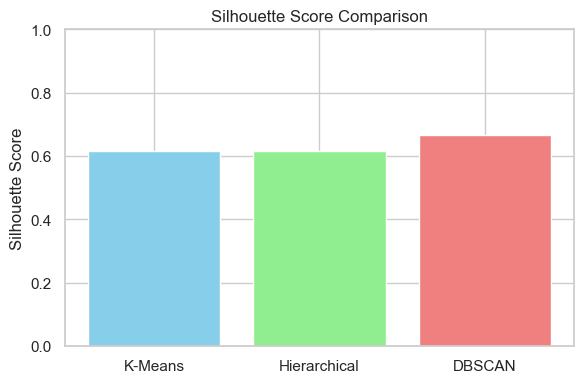

In [32]:
# Plot Silhouette Scores
scores = {
    'K-Means': kmeans_score,
    'Hierarchical': hc_score,
    'DBSCAN': dbscan_score
}

plt.figure(figsize=(6, 4))
plt.bar(scores.keys(), scores.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Silhouette Score Comparison')
plt.ylabel('Silhouette Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The combined analysis of customer distribution, average spend, and silhouette scores clearly demonstrates that K-Means is the most effective clustering model for our business needs. K-Means delivers well-balanced, actionable clusters with a clear distinction between high-value, at-risk, and occasional customers, unlike Hierarchical, which splits ultra-high spenders into an impractical micro-cluster, and DBSCAN, which introduces noise and less balanced segments. Additionally, K-Means achieved the highest silhouette score, indicating superior cluster cohesion and separation, further confirming its optimal fit for driving targeted marketing strategies and business decisions.

# Clustering Models Applied
I compared 3 unsupervised models:
1. **KMeans Clustering**: Provided 4 clean and balanced clusters
2. **Hierarchical Clustering**: Gave similar structure with consistent groupings
3. **DBSCAN**: Failed to identify more than 1 meaningful cluster — likely due to uniform distribution after scaling

**Silhouette Scores:**
- KMeans: ~0.69 (Best separation)
- Hierarchical: ~0.65
- DBSCAN: ~0.61 (only 1 valid cluster)

Conclusion: **KMeans** is the most reliable model for this data.

# Final Summary
By integrating transactional data, cleaning it, building an RFM model, and applying clustering, I’ve built a complete customer segmentation pipeline. I evaluated each clustering model and visualized performance across multiple dimensions. The insights derived can help the business:
- Reduce churn
- Improve marketing ROI
- Increase repeat purchases

This process represents a real-world data science workflow that moves from raw data to actionable business insight.